In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas
import matplotlib.patheffects as path_effects
from scipy.stats import skew, kurtosis
import svgutils.compose as sc

In [2]:
'''
20230127 - What is the expected return from auto-rolling a position every week with shorting

Figure 1: Autoroll/rebuy/hold vs price
Figure 2: returns distribution + stats
Figure 3: 

'''

'\n20230127 - What is the expected return from auto-rolling a position every week with shorting\n\nFigure 1: Autoroll/rebuy/hold vs price\nFigure 2: returns distribution + stats\nFigure 3: \n\n'

In [3]:
loadData=True
if loadData:
    # Load data from ETH-UNI-30bps pool
    ETHUNI30=pandas.read_gbq("SELECT DISTINCT * FROM `arcane-world-371019.First_sync.1` WHERE address='0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801' ORDER BY block_number, transaction_index  ", "arcane-world-371019")
    ETHUNI30.to_pickle('ETH-UNI-30bps.pkl')
    loadData = False
    
    
    

In [311]:
ticks30 = []
sqrtPrice30 = []
block30 = []
timestamp30 = []
unixtime30 = []
for index, row in ETHUNI30.iterrows():
    ticks30.append(row['tick'])
    sqrtPrice30.append((int(row['sqrtPrice'], 16)/2**96))
    block30.append(row['block_number'])
    timestamp30.append((row['block_timestamp']))
    unixtime30.append(row['block_timestamp'].timestamp())
ticks30 = np.array(ticks30)
block30 = np.array(block30)
sqrtPrice30 = np.array(sqrtPrice30)
unixtime30 = np.array(unixtime30)

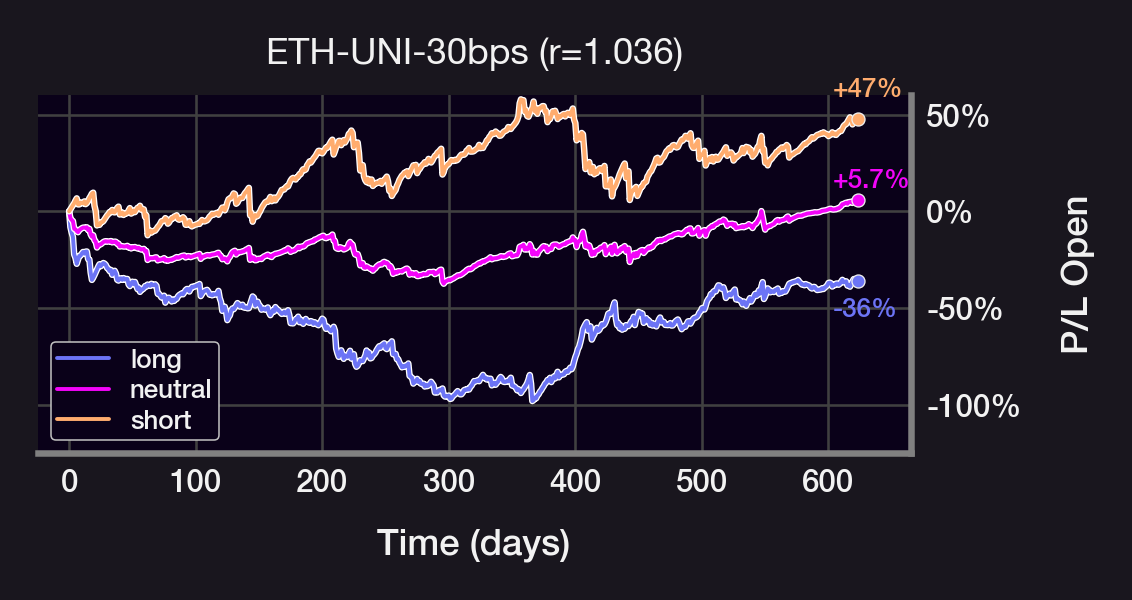

In [443]:
V = lambda x, k, r: (x<k/r)*x + (x>=k/r)*(x<=k*r)*(2*np.sqrt(x*k*r)-k-x)/(r-1) + (x>k*r)*k
X = lambda x, k, r, dL: (x<k/r)*dL*(1/np.sqrt(k/r) - 1/np.sqrt(k*r)) + (x>=k/r)*(x<=k*r)*dL*(1/np.sqrt(x) - 1/np.sqrt(k*r)) + (x>k*r)*0
Y = lambda x, k, r, dL: (x<k/r)*0 + (x>=k/r)*(x<=k*r)*dL*(np.sqrt(x) - np.sqrt(k/r)) + (x>k*r)*dL*(np.sqrt(k*r) - np.sqrt(k/r))                                                                                            
positionSize = 0.5*10**18
w = 360
r = 1.0001**w
nSecs=24*3600
fee = 30/10000.
df0 = []
df1 = []
stratLong = [0]
stratLongNF = [0]
stratNeutral = [0]
stratNeutralNF = [0]
stratShort = [0]
stratShortNF = [0]
rebuy = [0]
hold = []
DCA = []
feesVal = [0]
rebalanceTick = []

for i, t in enumerate(timestamp30):
  
    if i == 0:
        startDay = t
        startTick = ticks30[i]
        startSqrtPrice = sqrtPrice30[i]
        startPrice = sqrtPrice30[i]**2
        startLiqY = positionSize / (np.sqrt(startPrice) - np.sqrt(startPrice/r))
        startLiqX = positionSize*np.sqrt(r) / (np.sqrt(startPrice*r) - np.sqrt(startPrice))
        startLiq = np.min((startLiqX, startLiqY))
        startX = X(startPrice, startPrice, r, startLiq)
        startY = Y(startPrice, startPrice, r, startLiq)
        previousTick = ticks30[i]
        previoussqrtPrice = sqrtPrice30[i]
        
        positionRange = range(startTick - w, startTick + w)
    else:
       
        currentTick = ticks30[i]
        currentsqrtPrice = sqrtPrice30[i] 
        if (currentTick in positionRange or # If current or previous tick is in range
            previousTick in positionRange or
            (currentTick < positionRange[0] and previousTick > positionRange[-1]) or # if the current and previous ticks straddle the range
            (currentTick > positionRange[-1] and previousTick < positionRange[0])):
          

            
            dT = currentsqrtPrice - previoussqrtPrice


            if dT >= 0: ## price went up -> tokenX was purchased, tokenY was sold -> commission out of sold token = tokenY
                pLow = np.max([previoussqrtPrice, np.sqrt(1.0001**(startTick-w))])
                pHigh = np.min([currentsqrtPrice, np.sqrt(1.0001**(startTick+w))])
                dy = startLiq * (pHigh - pLow)
                df1.append(dy*fee)
            else: ## price went down -> tokenY was purchased, tokenX was sold -> commission out of sold token = tokenX
                pLow = np.max([currentsqrtPrice, np.sqrt(1.0001**(startTick-w))])
                pHigh = np.min([previoussqrtPrice, np.sqrt(1.0001**(startTick+w))])
                dx = startLiq * (1/pLow-1/pHigh)
                df0.append(dx*fee)

  
        previousTick = ticks30[i]+0 
        previoussqrtPrice = sqrtPrice30[i]+0
    if (t-startDay).total_seconds()>=nSecs: 

        rebalanceTick.append(i)
        
        endX = X(currentsqrtPrice**2, startPrice, r, startLiq)
        feesX = sum(df0)
        endY = Y(currentsqrtPrice**2, startPrice, r, startLiq)
        feesY = sum(df1)

        feesVal.append(sum(df1) + sum(df0) * currentsqrtPrice**2)
        df0 = []
        df1 = []
        # Buy startX tokens, supply startY 
        # -> sell endX 
        # -> look at (endY-startY) + (endX*endPrice - startX*startPrice)
        stratLong.append(((endY+feesY) - startY + # ETH difference balance(end)-balance(start)
                          (endX+feesX)*currentsqrtPrice**2 - startX*startPrice) / # token difference 
                         2/positionSize)
        stratLongNF.append(((endY) - startY + # ETH difference balance(end)-balance(start)
                          (endX)*currentsqrtPrice**2 - startX*startPrice) / # token difference 
                         2/positionSize)        
        
        # Borrow startX tokens, supply startY 
        # -> repay startX,  sell (endX-startX) 
        # -> look at (endY-startY) + (endX-startX)*endPrice
        stratNeutral.append(((endX-startX+feesX)*currentsqrtPrice**2 + # look at remaining X balance after repaying borrowed tokens 
                             (endY+feesY) -startY) /
                            2/positionSize)
        stratNeutralNF.append(((endX-startX)*currentsqrtPrice**2 + # look at remaining X balance after repaying borrowed tokens 
                             (endY) -startY) /
                            2/positionSize)        
        # borrow 2*startX tokens, buy startY with 1*startX
        # -> repay 2*startX, sell (endX - 2*startX)
        # -> look at endY + (endX - 2*startX)*endPrice
        stratShort.append(((endX-2*startX+feesX)*currentsqrtPrice**2 + # look at remaining X balance after repaying borrowed tokens 
                             (endY + feesY)) / # premium received from shorting
                          2/positionSize)
        stratShortNF.append(((endX-2*startX)*currentsqrtPrice**2 + # look at remaining X balance after repaying borrowed tokens 
                             (endY)) / # premium received from shorting
                          2/positionSize)     
        rebuy.append((currentsqrtPrice**2/startPrice-1))
        hold.append(currentsqrtPrice**2/sqrtPrice30[0]**2)
        DCA.append(currentsqrtPrice**2)

        startDay = t
        startTick = ticks30[i]
        startSqrtPrice = sqrtPrice30[i]
        startPrice = sqrtPrice30[i]**2
        startLiq = positionSize / (np.sqrt(startPrice) - np.sqrt(startPrice/r))
        startX = X(startPrice, startPrice, r, startLiq)
        startY = Y(startPrice, startPrice, r, startLiq)
        positionRange = range(startTick - w, startTick + w)
        
        
plt.style.use('../../stylesheet/panoptic-dark-16_9.mplstyle')

plt.plot(np.cumsum(stratLong), lw=1.25, color='w', zorder=3)
plt.plot(np.cumsum(stratLong), label='long', zorder=3)
plt.plot(len(stratLong), sum(stratLong),'o', zorder=4, ms=2.5, mec='#efefef', color='#6c74f5')
plt.text(len(stratLong)-20, sum(stratLong)-0.15, '-'+str(sum(stratLong)*100)[1:3]+'%', ha='left', va='center', fontsize=5, color='#6c74f5')

plt.plot(np.cumsum(stratNeutral), lw=1.25, color='w', zorder=3)
plt.plot(np.cumsum(stratNeutral), label='neutral', zorder=3, color='#f305f9')
plt.plot(len(stratLong), sum(stratNeutral),'o', zorder=4, ms=2.5, mec='#efefef', color='#f305f9')
plt.text(len(stratLong)-20, sum(stratNeutral)+0.1, '+'+str(sum(stratNeutral)*100)[:3]+'%', ha='left', va='center', fontsize=5, color='#f305f9')

plt.plot(np.cumsum(stratShort), lw=1.25, color='w', zorder=3)
plt.plot(np.cumsum(stratShort), label='short', zorder=3, color='#ffac6e')
plt.plot(len(stratLong), sum(stratShort),'o', zorder=4, ms=2.5, mec='#efefef', color='#ffac6e')
plt.text(len(stratLong)-20, sum(stratShort)+0.15, '+'+str(sum(stratShort)*100)[:2]+'%', ha='left', va='center', fontsize=5, color='#ffac6e')

#plt.plot(np.cumsum(rebuy), label='1d buy/sell')
#plt.plot(np.cumsum(DCA[-1]-DCA), label='DCA')
#plt.plot((np.array(hold)-hold[0]), label='Lump-sum investment', color='#f8d120')

plt.xlim((-25, 665))
plt.ylim((-1.25, 0.6))

plt.yticks([0.5, 0, -0.5, -1])
plt.gca().set_yticklabels([f'{(x):.0%}' for x in plt.gca().get_yticks()]) 

plt.title('ETH-UNI-30bps (r=1.036)')

plt.xlabel('Time (days)')
plt.ylabel('P/L Open', labelpad=-203)
plt.legend()   

plt.savefig('ETH-Returns-1.svg')
plt.savefig('ETH-Returns-1.png', dpi=750)


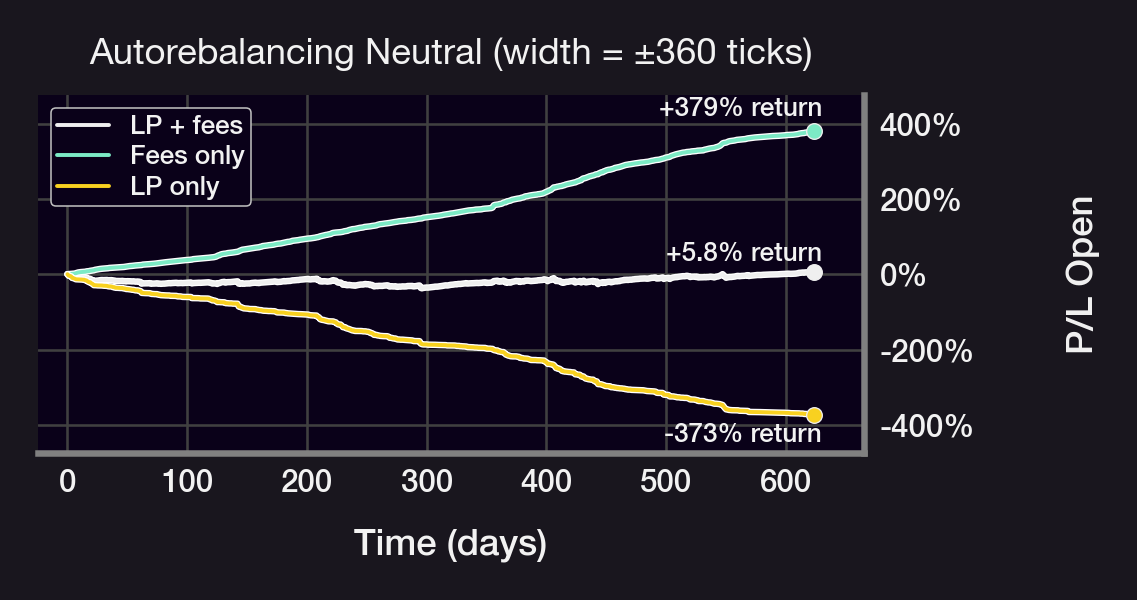

In [444]:
plt.style.use('../../stylesheet/panoptic-dark-16_9.mplstyle')

plt.plot(np.cumsum(np.array(stratNeutral)), lw=1.25, color='w')
plt.plot(np.cumsum(np.array(stratNeutral)), label='LP + fees', color='#efefef')

plt.plot(np.cumsum(np.array(feesVal)/2/positionSize), lw=1.25, color='w')
plt.plot(np.cumsum(np.array(feesVal)/2/positionSize), label='Fees only', color='#7ceac5')

plt.plot(np.cumsum(np.array(stratNeutralNF)), lw=1.25, color='w')
plt.plot(np.cumsum(np.array(stratNeutralNF)), label='LP only', color='#f8d120')


plt.plot(len(stratNeutral), sum(stratNeutral), 'o', ms=3, mec='#efefef', mfc='#efefef')
plt.plot(len(stratNeutral), sum(feesVal)/2/positionSize, 'o', ms=3, mec='#efefef', mfc='#7ceac5')
plt.plot(len(stratNeutral), sum(stratNeutralNF), 'o', ms=3, mec='#efefef', mfc='#f8d120')

plt.text(630, 0.35, '+5.8% return', fontsize=5, ha='right')
plt.text(630, 4.2, '+379% return', fontsize=5, ha='right')
plt.text(630, -4.45, '-373% return', fontsize=5, ha='right')

plt.legend()

plt.yticks([-4, -2, 0, 2, 4])
plt.gca().set_yticklabels([f'{(x):.0%}' for x in plt.gca().get_yticks()]) 

plt.xlim((-25, 665))
plt.ylim((-4.75, 4.75))
plt.xlabel('Time (days)')
plt.ylabel('P/L Open', labelpad=-204)
plt.title('Autorebalancing Neutral (width = ±360 ticks)')

plt.savefig('ETH-Returns-2.svg')
plt.savefig('ETH-Returns-2.png', dpi=750)

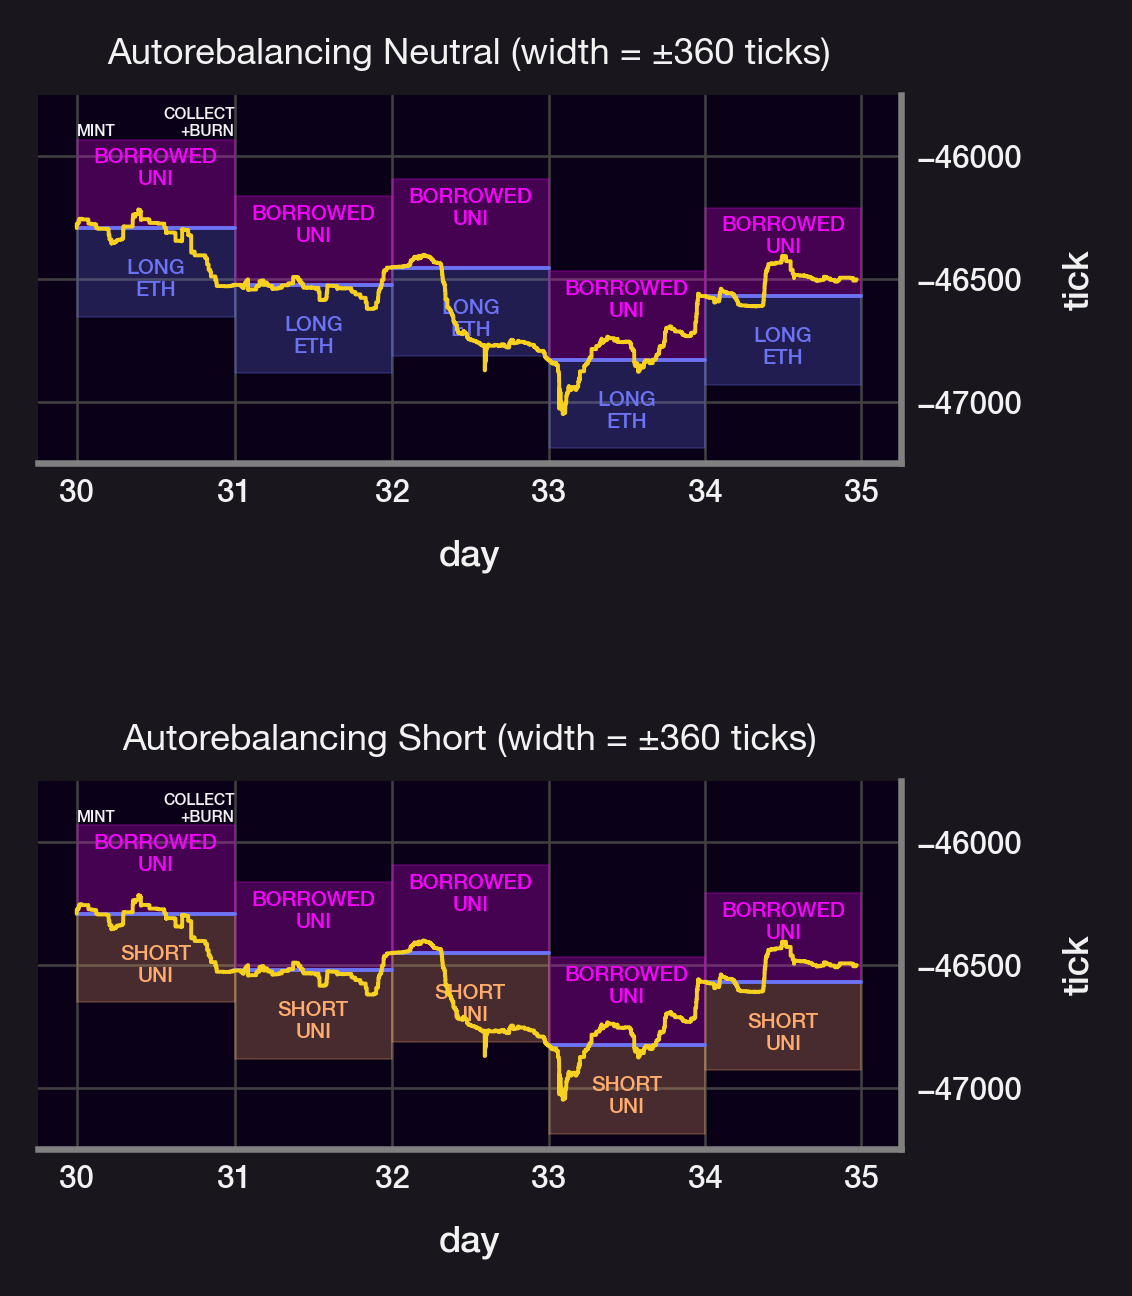

In [445]:
plt.style.use('../../stylesheet/panoptic-dark-7_8.mplstyle')
st = rebalanceTick[30]
en = rebalanceTick[35]
plt.subplot(2, 1,1)
plt.step(block30[st:en], ticks30[st:en], color='#f8d120', zorder=10)
plt.xticks(block30[rebalanceTick[30:36]],range(30,36)) 

for i in range(30, 35):
    plt.fill_between(block30[rebalanceTick[i:(i+2)]], 
                     [ticks30[rebalanceTick[i]]+360, ticks30[rebalanceTick[i]]+360], 
                     [ticks30[rebalanceTick[i]], ticks30[rebalanceTick[i]]], 
                     color='#f305f9', alpha=0.25)
    plt.fill_between(block30[rebalanceTick[i:(i+2)]], 
                     [ticks30[rebalanceTick[i]], ticks30[rebalanceTick[i]]], 
                     [ticks30[rebalanceTick[i]]-360, ticks30[rebalanceTick[i]]-360], 
                     color='#6c74f5', alpha=0.25)    
    plt.plot(block30[rebalanceTick[i:(i+2)]],[ticks30[rebalanceTick[i]], ticks30[rebalanceTick[i]]], color='#6c74f5')
    plt.text(block30[rebalanceTick[i]]/2+block30[rebalanceTick[i+1]]/2, ticks30[rebalanceTick[i]]+175 - (i%2)*0, 'BORROWED\nUNI', ha='center', fontsize=4, color='#f305f9') 
    plt.text(block30[rebalanceTick[i]]/2+block30[rebalanceTick[i+1]]/2, ticks30[rebalanceTick[i]]-275 - (i%2)*0, 'LONG\nETH', ha='center', fontsize=4, color='#6c74f5') 
    if i == 30:
        plt.text(block30[rebalanceTick[i]], ticks30[rebalanceTick[i]]+375 - (i%2)*800, 'MINT', ha='left', fontsize=3)
        plt.text(block30[rebalanceTick[i+1]], ticks30[rebalanceTick[i]]+375 - (i%2)*875, 'COLLECT\n+BURN', ha='right', fontsize=3)
plt.xlabel('day')
plt.ylabel('tick', labelpad=-203)
plt.title('Autorebalancing Neutral (width = ±360 ticks)')
plt.ylim((-47250, -45750))
plt.subplot(2, 1,2)


plt.step(block30[st:en], ticks30[st:en], color='#f8d120', zorder=10)
plt.xticks(block30[rebalanceTick[30:36]],range(30,36)) 

for i in range(30, 35):
    plt.fill_between(block30[rebalanceTick[i:(i+2)]], 
                     [ticks30[rebalanceTick[i]]+360, ticks30[rebalanceTick[i]]+360], 
                     [ticks30[rebalanceTick[i]], ticks30[rebalanceTick[i]]], 
                     color='#f305f9', alpha=0.25)
    plt.fill_between(block30[rebalanceTick[i:(i+2)]], 
                     [ticks30[rebalanceTick[i]], ticks30[rebalanceTick[i]]], 
                     [ticks30[rebalanceTick[i]]-360, ticks30[rebalanceTick[i]]-360], 
                     color='#ffac6e', alpha=0.25)    
    plt.plot(block30[rebalanceTick[i:(i+2)]],[ticks30[rebalanceTick[i]], ticks30[rebalanceTick[i]]], color='#6c74f5')
    plt.text(block30[rebalanceTick[i]]/2+block30[rebalanceTick[i+1]]/2, ticks30[rebalanceTick[i]]+175 - (i%2)*0, 'BORROWED\nUNI', ha='center', fontsize=4, color='#f305f9') 
    plt.text(block30[rebalanceTick[i]]/2+block30[rebalanceTick[i+1]]/2, ticks30[rebalanceTick[i]]-275 - (i%2)*0, 'SHORT\nUNI', ha='center', fontsize=4, color='#ffac6e') 
    if i ==30:
        plt.text(block30[rebalanceTick[i]], ticks30[rebalanceTick[i]]+375 - (i%2)*800, 'MINT', ha='left', fontsize=3)
        plt.text(block30[rebalanceTick[i+1]], ticks30[rebalanceTick[i]]+375 - (i%2)*875, 'COLLECT\n+BURN', ha='right', fontsize=3)
plt.xlabel('day')
plt.ylabel('tick', labelpad=-203)
plt.title('Autorebalancing Short (width = ±360 ticks)')
plt.ylim((-47250, -45750))          

plt.savefig('ETH-Dist-1.svg')
plt.savefig('ETH-Dist-1.png', dpi=750)
           

/var/folders/n4/dw74sg2n5s9crdkbbv0m1hh80000gn/T/ipykernel_1813/74135438.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{(x/100):.0%}' for x in plt.gca().get_xticks()])
/var/folders/n4/dw74sg2n5s9crdkbbv0m1hh80000gn/T/ipykernel_1813/74135438.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{(x/100):.0%}' for x in plt.gca().get_xticks()])


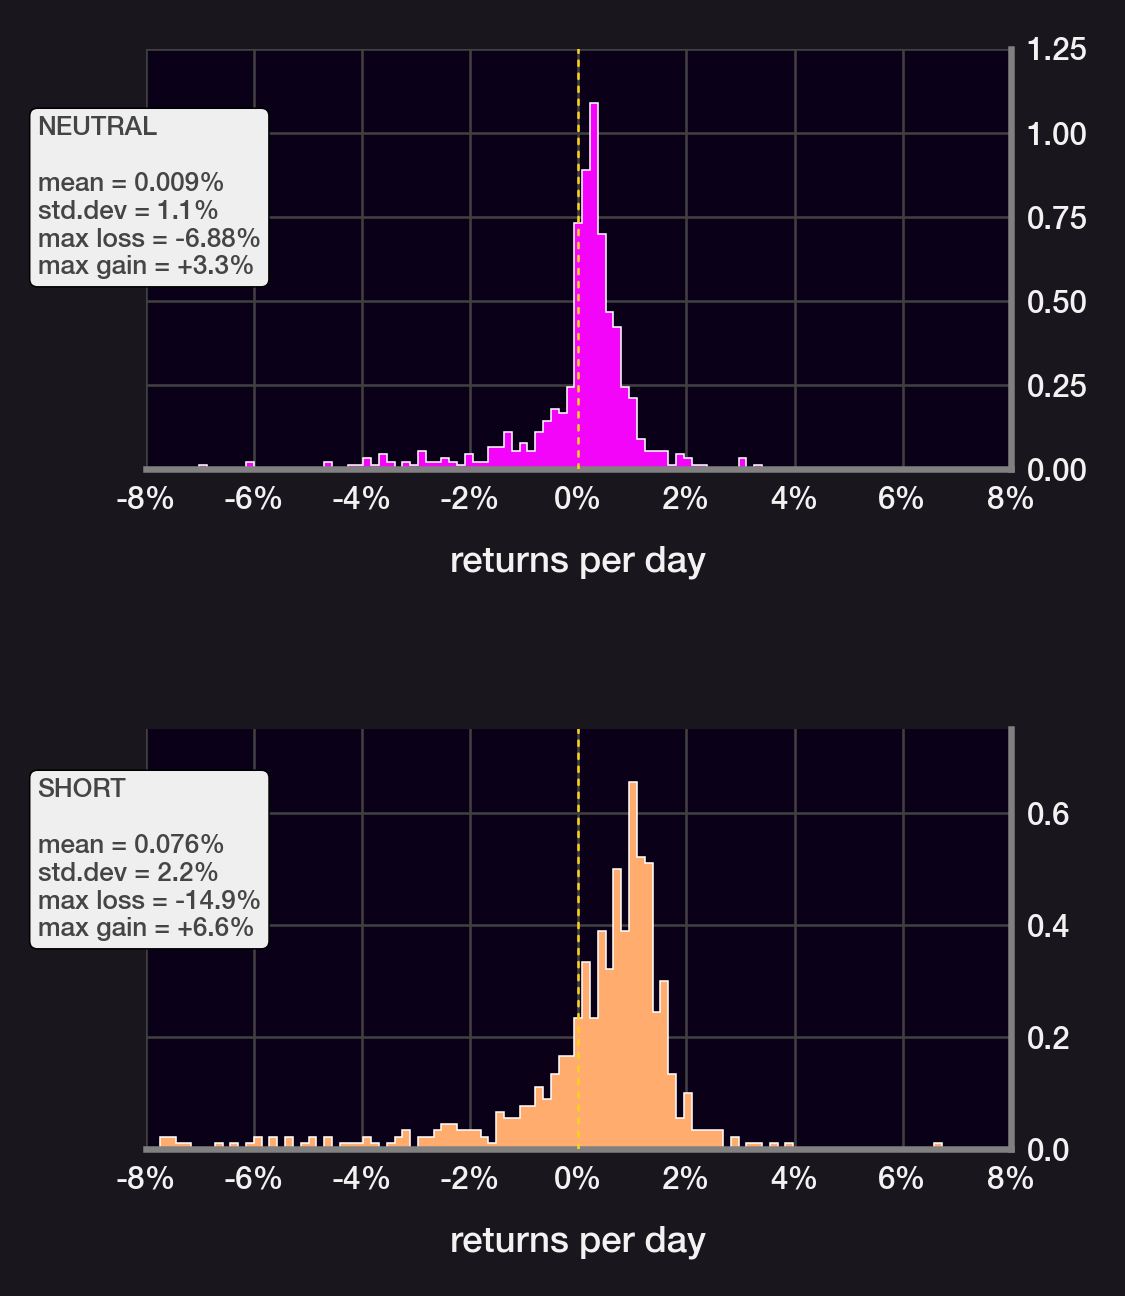

In [446]:
plt.style.use('../../stylesheet/panoptic-dark-7_8.mplstyle')
plt.subplot(2, 1,1)

plt.plot([0, 0],[0, 1.5], lw=0.5, color='#f8d120', dashes=(2, 3), zorder=4, alpha=1) 

plt.hist(np.array(stratNeutral)*100, np.linspace(-18, 18, 250), density=True, label='buy/sell\nper day returns', ec='w', color='#f305f9', histtype='stepfilled')
plt.text(-10, 0.58, 'NEUTRAL\n\nmean = '+str(np.mean(stratNeutral)*100)[:5]+'%\nstd.dev = '+str(np.std(stratNeutral)*100)[:3]+'%\nmax loss = '+str(min(stratNeutral)*100)[:5]+'%\nmax gain = +'+str(max(stratNeutral)*100)[:3]+'%', color='#454545', fontsize=5, bbox=dict(boxstyle='round', fc="#efefef", ec="k"))

plt.xlim((-8, 8))
plt.ylim((0, 1.25))
plt.xlabel('returns per day')
plt.gca().set_xticklabels([f'{(x/100):.0%}' for x in plt.gca().get_xticks()]) 

plt.subplot(2, 1,2)
plt.plot([0, 0],[0, 1.5], lw=0.5, color='#f8d120', dashes=(2, 3), zorder=4, alpha=1) 

plt.hist(np.array(stratShort)*100, np.linspace(-18, 18, 250), density=True, label='buy/sell\nper day returns', ec='w', color='#ffac6e', histtype='stepfilled')
plt.text(-10, 0.38, 'SHORT\n\nmean = '+str(np.mean(stratShort)*100)[:5]+'%\nstd.dev = '+str(np.std(stratShort)*100)[:3]+'%\nmax loss = '+str(min(stratShort)*100)[:5]+'%\nmax gain = +'+str(max(stratShort)*100)[:3]+'%', color='#454545', fontsize=5, bbox=dict(boxstyle='round', fc="#efefef", ec="k"))

plt.xlim((-8, 8))
plt.ylim((0, 0.75))
plt.xlabel('returns per day')
plt.gca().set_xticklabels([f'{(x/100):.0%}' for x in plt.gca().get_xticks()]) 

plt.savefig('ETH-Dist-2.svg')
plt.savefig('ETH-Dist-2.png', dpi=750)

In [447]:
loadData=False
if loadData:
    # Load data from RAI-DAI-5bps pool
    RAIDAI5=pandas.read_gbq("SELECT DISTINCT * FROM `arcane-world-371019.First_sync.1` WHERE address='0xcb0c5d9d92f4f2f80cce7aa271a1e148c226e19d' ORDER BY block_number, transaction_index  ", "arcane-world-371019")
    RAIDAI5.to_pickle('RAI-DAI-5bps.pkl')
    loadData = False   

ticks5 = []
sqrtPrice5 = []
block5 = []
timestamp5 = []
unixtime5 = []
for index, row in RAIDAI5.iterrows():
    ticks5.append(row['tick'])
    sqrtPrice5.append((int(row['sqrtPrice'], 16)/2**96))
    block5.append(row['block_number'])
    timestamp5.append((row['block_timestamp']))
    unixtime5.append(row['block_timestamp'].timestamp())
timestamp5 = timestamp5[800:]
ticks5 = np.array(ticks5[800:])
block5 = np.array(block5[800:])
sqrtPrice5 = np.array(sqrtPrice5[800:])
unixtime5 = np.array(unixtime5[800:])


172


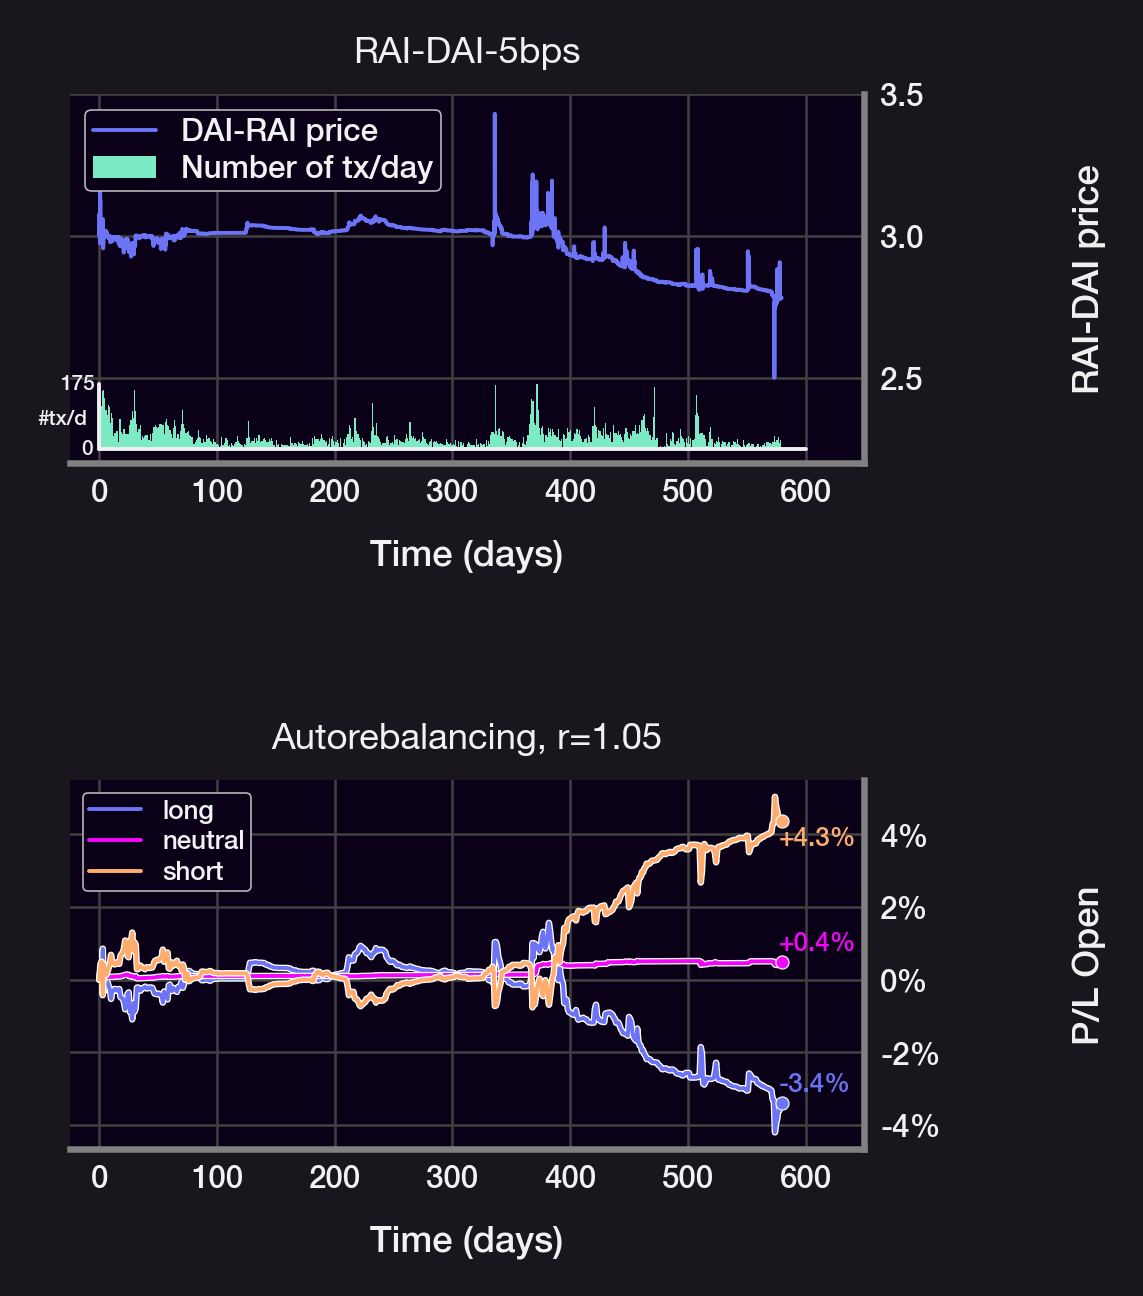

In [448]:

plt.style.use('../../stylesheet/panoptic-dark-7_8.mplstyle')
plt.subplot(2,1,1)
plt.title('RAI-DAI-5bps')

price5 = []
nTx = []
days = []
nSecs=3600*24
for i, t in enumerate(timestamp5):
    if i == 0:
        startDay = t
        k = 0
        pTemp = []
    k += 1   
    pTemp.append(ticks5[i])
    if (t-startDay).total_seconds()>=nSecs:   
        price5.append(np.mean(pTemp))
        nTx.append(k)
        days.append(unixtime5[i])
        startDay = t
        k = 0
plt.plot((unixtime5-unixtime5[0])/3600/24*594/630, sqrtPrice5**2, label='DAI-RAI price')        
plt.bar((np.array(days) - unixtime5[0])/3600/24*594/630, np.array(nTx)/750, 1, 2.25, color='#7ceac5', label='Number of tx/day')
plt.ylim((2.2, 3.5))
plt.xlim((-25, 650))
print(np.max(np.array(nTx)))
plt.plot([0, 0], [2.25, 2.25+172/750], lw=0.75, color='#efefef')
plt.plot([0, 600], [2.25, 2.25], lw=0.75, color='#efefef')
plt.text(-10, 2.25, '0', ha='center', va='center', rotation=0, fontsize=4, color='#efefef')
plt.text(-3, 2.25+172/750, '175', ha='right', va='center', rotation=0, fontsize=4, color='#efefef')
plt.text(-10, 2.25+80/750, '#tx/d', ha='right', va='center', rotation=0, fontsize=4, color='#efefef')
plt.xlabel('Time (days)')
plt.ylabel('RAI-DAI price', labelpad=-199)
plt.legend()



plt.subplot(2,1,2)
V = lambda x, k, r: (x<k/r)*x + (x>=k/r)*(x<=k*r)*(2*np.sqrt(x*k*r)-k-x)/(r-1) + (x>k*r)*k
X = lambda x, k, r, dL: (x<k/r)*dL*(1/np.sqrt(k/r) - 1/np.sqrt(k*r)) + (x>=k/r)*(x<=k*r)*dL*(1/np.sqrt(x) - 1/np.sqrt(k*r)) + (x>k*r)*0
Y = lambda x, k, r, dL: (x<k/r)*0 + (x>=k/r)*(x<=k*r)*dL*(np.sqrt(x) - np.sqrt(k/r)) + (x>k*r)*dL*(np.sqrt(k*r) - np.sqrt(k/r))                                                                                            
positionSize = 0.5*10**18
w = 490
r = 1.0001**w
nSecs=3600*24
fee = 5/10000.
df0 = []
df1 = []
stratLong = [0]
stratLongNF = [0]
stratNeutral = [0]
stratNeutralNF = [0]
stratShort = [0]
stratShortNF = [0]
rebuy = [0]
hold = []
DCA = []
feesVal = [0]
rebalanceTick = []

for i, t in enumerate(timestamp5):
  
    if i == 0:
        startDay = t
        startTick = ticks5[i]
        startSqrtPrice = sqrtPrice5[i]
        startPrice = sqrtPrice5[i]**2
        startLiq = positionSize / (np.sqrt(startPrice) - np.sqrt(startPrice/r))
        startX = X(startPrice, startPrice, r, startLiq)
        startY = Y(startPrice, startPrice, r, startLiq)
        previousTick = ticks5[i]
        previoussqrtPrice = sqrtPrice5[i]
        
        positionRange = range(startTick - w, startTick + w)
    else:
       
        currentTick = ticks5[i]
        currentsqrtPrice = sqrtPrice5[i]
 
        if (currentTick in positionRange or
            previousTick in positionRange or
            (currentTick < positionRange[0] and previousTick > positionRange[-1]) or
            (currentTick > positionRange[-1] and previousTick < positionRange[0])):
          
            dT = currentsqrtPrice - previoussqrtPrice   
            if dT >= 0:
                pLow = np.max([previoussqrtPrice, np.sqrt(1.0001**(startTick-w))])
                pHigh = np.min([currentsqrtPrice, np.sqrt(1.0001**(startTick+w))])
                dy = startLiq * (pHigh - pLow)
                df1.append(dy*fee)
            else:
                pLow = np.max([currentsqrtPrice, np.sqrt(1.0001**(startTick-w))])
                pHigh = np.min([previoussqrtPrice, np.sqrt(1.0001**(startTick+w))])
                dx = startLiq * (1/pLow-1/pHigh)
                df0.append(dx*fee)    
  
        previousTick = ticks5[i]+0 
        previoussqrtPrice = sqrtPrice5[i]+0
    if (t-startDay).total_seconds()>=nSecs: 

        rebalanceTick.append(i)
        
        endX = X(currentsqrtPrice**2, startPrice, r, startLiq)
        feesX = sum(df0)
        endY = Y(currentsqrtPrice**2, startPrice, r, startLiq)
        feesY = sum(df1)

        feesVal.append(sum(df1) + sum(df0) * currentsqrtPrice**2)
        df0 = []
        df1 = []
        # Buy startX tokens, supply startY 
        # -> sell endX 
        # -> look at (endY-startY) + (endX*endPrice - startX*startPrice)
        stratLong.append(((endY+feesY) - startY + # ETH difference balance(end)-balance(start)
                          (endX+feesX)*currentsqrtPrice**2 - startX*startPrice) / # token difference 
                         2/positionSize)
        stratLongNF.append(((endY) - startY + # ETH difference balance(end)-balance(start)
                          (endX)*currentsqrtPrice**2 - startX*startPrice) / # token difference 
                         2/positionSize)        
        
        # Borrow startX tokens, supply startY 
        # -> repay startX,  sell (endX-startX) 
        # -> look at (endY-startY) + (endX-startX)*endPrice
        stratNeutral.append(((endX-startX+feesX)*currentsqrtPrice**2 + # look at remaining X balance after repaying borrowed tokens 
                             (endY+feesY) -startY) /
                            2/positionSize)
        stratNeutralNF.append(((endX-startX)*currentsqrtPrice**2 + # look at remaining X balance after repaying borrowed tokens 
                             (endY) -startY) /
                            2/positionSize)        
        # borrow 2*startX tokens, buy startY with 1*startX
        # -> repay 2*startX, sell (endX - 2*startX)
        # -> look at endY + (endX - 2*startX)*endPrice
        stratShort.append(((endX-2*startX+feesX)*currentsqrtPrice**2 + # look at remaining X balance after repaying borrowed tokens 
                             (endY + feesY)) / # premium received from shorting
                          2/positionSize)
        stratShortNF.append(((endX-2*startX)*currentsqrtPrice**2 + # look at remaining X balance after repaying borrowed tokens 
                             (endY)) / # premium received from shorting
                          2/positionSize)
        
        rebuy.append((currentsqrtPrice**2/startPrice-1))
        hold.append(currentsqrtPrice**2/sqrtPrice5[0]**2)
        DCA.append(currentsqrtPrice**2)

        startDay = t
        startTick = ticks5[i]
        startSqrtPrice = sqrtPrice5[i]
        startPrice = sqrtPrice5[i]**2
        startLiq = positionSize / (np.sqrt(startPrice) - np.sqrt(startPrice/r))
        startX = X(startPrice, startPrice, r, startLiq)
        startY = Y(startPrice, startPrice, r, startLiq)
        positionRange = range(startTick - w, startTick + w)
        
        
plt.style.use('../../stylesheet/panoptic-dark-16_9.mplstyle')

plt.plot(np.cumsum(stratLong), lw=1.25, color='w', zorder=3)
plt.plot(np.cumsum(stratLong), label='long', zorder=3,color='#6c74f5')
plt.plot(len(stratLong), sum(stratLong),'o', zorder=4, ms=2.5, mec='#efefef', color='#6c74f5')
plt.text(len(stratLong)-3, sum(stratLong)+0.005, '-'+str(sum(stratLong)*100)[1:4]+'%', ha='left', va='center', fontsize=5, color='#6c74f5')

plt.plot(np.cumsum(stratNeutral), lw=1.25, color='w', zorder=3)
plt.plot(np.cumsum(stratNeutral), label='neutral', zorder=3, color='#f305f9')
plt.plot(len(stratLong), sum(stratNeutral),'o', zorder=4, ms=2.5, mec='#efefef', color='#f305f9')
plt.text(len(stratLong)-3, sum(stratNeutral)+0.005, '+'+str(sum(stratNeutral)*100)[:3]+'%', ha='left', va='center', fontsize=5, color='#f305f9')

plt.plot(np.cumsum(stratShort), lw=1.25, color='w', zorder=3)
plt.plot(np.cumsum(stratShort), label='short', zorder=3, color='#ffac6e')
plt.plot(len(stratLong), sum(stratShort),'o', zorder=4, ms=2.5, mec='#efefef', color='#ffac6e')
plt.text(len(stratLong)-3, sum(stratShort)-0.005, '+'+str(sum(stratShort)*100)[:3]+'%', ha='left', va='center', fontsize=5, color='#ffac6e')

#plt.plot(np.cumsum(rebuy), label='1d buy/sell')
#plt.plot(np.cumsum(DCA[-1]-DCA), label='DCA')
#plt.plot((np.array(hold)-hold[0]), label='Lump-sum investment', color='#f8d120')

plt.yticks([-0.04, -0.02, 0, 0.02, 0.04])
plt.gca().set_yticklabels([f'{(x):.0%}' for x in plt.gca().get_yticks()]) 
#plt.ylim((-1.85, 0.1))
plt.xlim((-25, 650))

plt.title('Autorebalancing, r=1.05')
plt.xlabel('Time (days)')
plt.ylabel('P/L Open', labelpad=-199)
plt.legend()   
plt.tight_layout()
plt.savefig('RAI-Returns-1.svg')
plt.savefig('RAI-Returns-1.png', dpi=750)


In [449]:
loadData=False
if loadData:
    # Load data from RAI-DAI-5bps pool
    ETHSHIB30=pandas.read_gbq("SELECT DISTINCT * FROM `arcane-world-371019.First_sync.1` WHERE address='0x2f62f2b4c5fcd7570a709dec05d68ea19c82a9ec' ORDER BY block_number, transaction_index  ", "arcane-world-371019")
    ETHSHIB30.to_pickle('ETH-SHIB-30bps.pkl')
    loadData = False   

ticksB = []
sqrtPriceB = []
blockB = []
timestampB = []
unixtimeB = []
for index, row in ETHSHIB30.iterrows():
    ticksB.append(row['tick'])
    sqrtPriceB.append((int(row['sqrtPrice'], 16)/2**96))
    blockB.append(row['block_number'])
    timestampB.append((row['block_timestamp']))
    unixtimeB.append(row['block_timestamp'].timestamp())
timestampB = timestampB[1500:]
ticksB = np.array(ticksB[1500:])
blockB = np.array(blockB[1500:])
sqrtPriceB = np.array(sqrtPriceB[1500:])
unixtimeB = np.array(unixtimeB[1500:])

1935


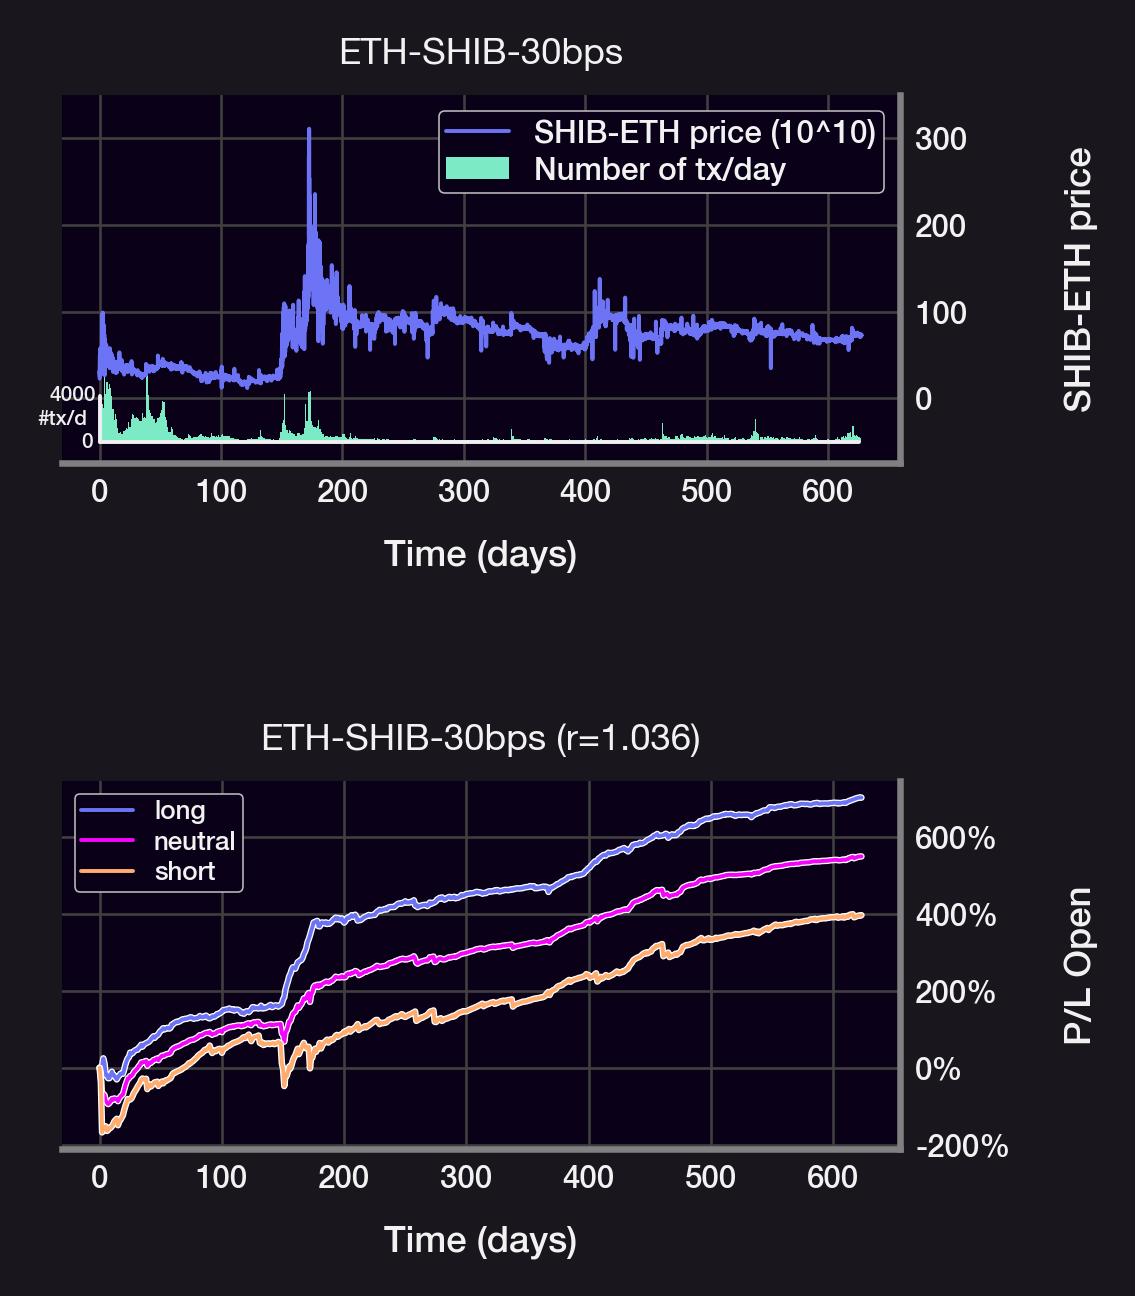

In [454]:
plt.style.use('../../stylesheet/panoptic-dark-7_8.mplstyle')
plt.subplot(2,1,1)
plt.title('ETH-SHIB-30bps')


nTx = []
days = []
nSecs=3600*24
for i, t in enumerate(timestampB):
    if i == 0:
        startDay = t
        k = 0
        pTemp = []
    k += 1   
    if (t-startDay).total_seconds()>=nSecs:   
        nTx.append(k)
        days.append(unixtimeB[i])
        startDay = t
        k = 0
plt.plot((unixtimeB-unixtimeB[0])/3600/24, 10**10*sqrtPriceB**2, label='SHIB-ETH price (10^10)')        
plt.bar((np.array(days) - unixtimeB[0])/3600/24, np.array(nTx)/75, 1, -50, color='#7ceac5', label='Number of tx/day')
plt.ylim((-75, 350))
#plt.xlim((-25, 625))
print(np.max(np.array(nTx[int(len(nTx)/2):])))
plt.plot([0, 0], [-50, -50+4000/75], lw=0.75, color='#efefef')
plt.plot([0, 625], [-50, -50], lw=0.75, color='#efefef')
plt.text(-10, -50, '0', ha='center', va='center', rotation=0, fontsize=4, color='#efefef')
plt.text(-3, -50+4000/75, '4000', ha='right', va='center', rotation=0, fontsize=4, color='#efefef')
plt.text(-10, -50+2000/75, '#tx/d', ha='right', va='center', rotation=0, fontsize=4, color='#efefef')
plt.xlabel('Time (days)')
plt.ylabel('SHIB-ETH price', labelpad=-199)
plt.legend()




plt.subplot(2,1,2)
V = lambda x, k, r: (x<k/r)*x + (x>=k/r)*(x<=k*r)*(2*np.sqrt(x*k*r)-k-x)/(r-1) + (x>k*r)*k
X = lambda x, k, r, dL: (x<k/r)*dL*(1/np.sqrt(k/r) - 1/np.sqrt(k*r)) + (x>=k/r)*(x<=k*r)*dL*(1/np.sqrt(x) - 1/np.sqrt(k*r)) + (x>k*r)*0
Y = lambda x, k, r, dL: (x<k/r)*0 + (x>=k/r)*(x<=k*r)*dL*(np.sqrt(x) - np.sqrt(k/r)) + (x>k*r)*dL*(np.sqrt(k*r) - np.sqrt(k/r))                                                                                            
positionSize = 0.5*10**18
w = 360
r = 1.0001**w
nSecs=3600*24
fee = 30/10000.
df0 = []
df1 = []
stratLong = [0]
stratLongNF = [0]
stratNeutral = [0]
stratNeutralNF = [0]
stratShort = [0]
stratShortNF = [0]
rebuy = [0]
hold = []
DCA = []
feesVal = [0]
rebalanceTick = []

for i, t in enumerate(timestampB):
  
    if i == 0:
        startDay = t
        startTick = ticksB[i]
        startSqrtPrice = sqrtPriceB[i]
        startPrice = sqrtPriceB[i]**2
        startLiq = positionSize / (np.sqrt(startPrice) - np.sqrt(startPrice/r))
        startX = X(startPrice, startPrice, r, startLiq)
        startY = Y(startPrice, startPrice, r, startLiq)
        previousTick = ticksB[i]
        previoussqrtPrice = sqrtPriceB[i]
        
        positionRange = range(startTick - w, startTick + w)
    else:
       
        currentTick = ticksB[i]
        currentsqrtPrice = sqrtPriceB[i]
 
        if (currentTick in positionRange or
            previousTick in positionRange or
            (currentTick < positionRange[0] and previousTick > positionRange[-1]) or
            (currentTick > positionRange[-1] and previousTick < positionRange[0])):
          
            dT = currentsqrtPrice - previoussqrtPrice   
            if dT >= 0:
                pLow = np.max([previoussqrtPrice, np.sqrt(1.0001**(startTick-w))])
                pHigh = np.min([currentsqrtPrice, np.sqrt(1.0001**(startTick+w))])
                dy = startLiq * (pHigh - pLow)
                df1.append(dy*fee)
            else:
                pLow = np.max([currentsqrtPrice, np.sqrt(1.0001**(startTick-w))])
                pHigh = np.min([previoussqrtPrice, np.sqrt(1.0001**(startTick+w))])
                dx = startLiq * (1/pLow-1/pHigh)
                df0.append(dx*fee)    
  
        previousTick = ticksB[i]+0 
        previoussqrtPrice = sqrtPriceB[i]+0
    if (t-startDay).total_seconds()>=nSecs: 

        rebalanceTick.append(i)
        
        endX = X(currentsqrtPrice**2, startPrice, r, startLiq)
        feesX = sum(df0)
        endY = Y(currentsqrtPrice**2, startPrice, r, startLiq)
        feesY = sum(df1)

        feesVal.append(sum(df1) + sum(df0) * currentsqrtPrice**2)
        df0 = []
        df1 = []
        # Buy startX tokens, supply startY 
        # -> sell endX 
        # -> look at (endY-startY) + (endX*endPrice - startX*startPrice)
        stratLong.append(((endY+feesY) - startY + # ETH difference balance(end)-balance(start)
                          (endX+feesX)*currentsqrtPrice**2 - startX*startPrice) / # token difference 
                         2/positionSize)
        stratLongNF.append(((endY) - startY + # ETH difference balance(end)-balance(start)
                          (endX)*currentsqrtPrice**2 - startX*startPrice) / # token difference 
                         2/positionSize)        
        
        # Borrow startX tokens, supply startY 
        # -> repay startX,  sell (endX-startX) 
        # -> look at (endY-startY) + (endX-startX)*endPrice
        stratNeutral.append(((endX-startX+feesX)*currentsqrtPrice**2 + # look at remaining X balance after repaying borrowed tokens 
                             (endY+feesY) -startY) /
                            2/positionSize)
        stratNeutralNF.append(((endX-startX)*currentsqrtPrice**2 + # look at remaining X balance after repaying borrowed tokens 
                             (endY) -startY) /
                            2/positionSize)        
        # borrow 2*startX tokens, buy startY with 1*startX
        # -> repay 2*startX, sell (endX - 2*startX)
        # -> look at endY + (endX - 2*startX)*endPrice
        stratShort.append(((endX-2*startX+feesX)*currentsqrtPrice**2 + # look at remaining X balance after repaying borrowed tokens 
                             (endY + feesY)) / # premium received from shorting
                          2/positionSize)
        stratShortNF.append(((endX-2*startX)*currentsqrtPrice**2 + # look at remaining X balance after repaying borrowed tokens 
                             (endY)) / # premium received from shorting
                          2/positionSize)
        
        rebuy.append((currentsqrtPrice**2/startPrice-1))
        hold.append(currentsqrtPrice**2/sqrtPriceB[0]**2)
        DCA.append(currentsqrtPrice**2)

        startDay = t
        startTick = ticksB[i]
        startSqrtPrice = sqrtPriceB[i]
        startPrice = sqrtPriceB[i]**2
        startLiq = positionSize / (np.sqrt(startPrice) - np.sqrt(startPrice/r))
        startX = X(startPrice, startPrice, r, startLiq)
        startY = Y(startPrice, startPrice, r, startLiq)
        positionRange = range(startTick - w, startTick + w)
        
        
plt.style.use('../../stylesheet/panoptic-dark-16_9.mplstyle')

plt.plot(np.cumsum(stratLong), lw=1.25, color='w', zorder=3)
plt.plot(np.cumsum(stratLong), label='long', zorder=3)
plt.plot(np.cumsum(stratNeutral), lw=1.25, color='w', zorder=3)
plt.plot(np.cumsum(stratNeutral), label='neutral', zorder=3, color='#f305f9')
plt.plot(np.cumsum(stratShort), lw=1.25, color='w', zorder=3)
plt.plot(np.cumsum(stratShort), label='short', zorder=3, color='#ffac6e')
#plt.plot(np.cumsum(rebuy), label='1d buy/sell')
#plt.plot(np.cumsum(DCA[-1]-DCA), label='DCA')
#plt.plot((np.array(hold)-hold[0]), label='Lump-sum investment', color='#f8d120')

plt.yticks([-2, 0, 2, 4, 6])
plt.gca().set_yticklabels([f'{(x):.0%}' for x in plt.gca().get_yticks()]) 
#plt.ylim((-1.85, 0.1))
#plt.xlim((-25, 625))

plt.title('ETH-SHIB-30bps (r=1.036)')
plt.xlabel('Time (days)')
plt.ylabel('P/L Open', labelpad=-199)
plt.legend()   
plt.tight_layout()
plt.savefig('SHIB-Returns-1.svg')
plt.savefig('SHIB-Returns-1.png', dpi=750)



In [ ]:
startPrice: 0.013340258766205489 ETH/UNI
endPrice: 0.012109039571673556
startX: 3.748053233169935e+19 UNI
endX: 7.564178834435971e+19 UNI
startY: 5e+17 ETH
endY: 0.0 ETH1
feesX: 1.490843905292455e+17 UNI
feesY: 450802406137980.4 ETH


SyntaxError: invalid syntax (1173666559.py, line 1)

In [391]:
## Long
print('Long: startValue = ',5e+17 + 3.748053233169935e+19*0.013340258766205489)
print('End: endValue = ',0 + 7.564178834435971e+19*0.012109039571673556)
print('fees: value = ',450802406137980.4+1.490843905292455e+17*0.012109039571673556)
print('profit = ', 0 + 7.564178834435971e+19*0.012109039571673556+450802406137980.4+1.490843905292455e+17*0.012109039571673556-5e+17 - 3.748053233169935e+19*0.013340258766205489)

Long: startValue =  1.0000000000000005e+18
End: endValue =  9.159494083340073e+17
fees: value =  2256071190575448.5
profit =  -8.179452047541766e+16


In [387]:
## Neutral
print('Long: startValue = ',5e+17)
print('End: endValue = ',0 + (7.564178834435971e+19-3.748053233169935e+19)*0.012109039571673556)
print('fees: value = ',450802406137980.4+1.490843905292455e+17*0.012109039571673556)
print('profit = ', 0 + (7.564178834435971e+19-3.748053233169935e+19)*0.012109039571673556+450802406137980.4+1.490843905292455e+17*0.012109039571673556-5e+17)

Long: startValue =  5e+17
End: endValue =  4.620961591620698e+17
fees: value =  2256071190575448.5
profit =  -3.564776964735475e+16


In [393]:
## short
print('Long: startValue = ',0)
print('End: endValue = ',0 + (7.564178834435971e+19-2*3.748053233169935e+19)*0.012109039571673556)
print('fees: value = ',450802406137980.4+1.490843905292455e+17*0.012109039571673556)
print('profit = ', 0 + (7.564178834435971e+19-2*3.748053233169935e+19)*0.012109039571673556+450802406137980.4+1.490843905292455e+17*0.012109039571673556)

Long: startValue =  0
End: endValue =  8242909990132275.0
fees: value =  2256071190575448.5
profit =  1.0498981180707724e+16


In [392]:
stratShort

[0, 0.010498981180707722]

In [459]:
1/min(1.0001**ticksB), 1/max(1.0001**ticksB)

(839882516.3163418, 32156838.99915822)

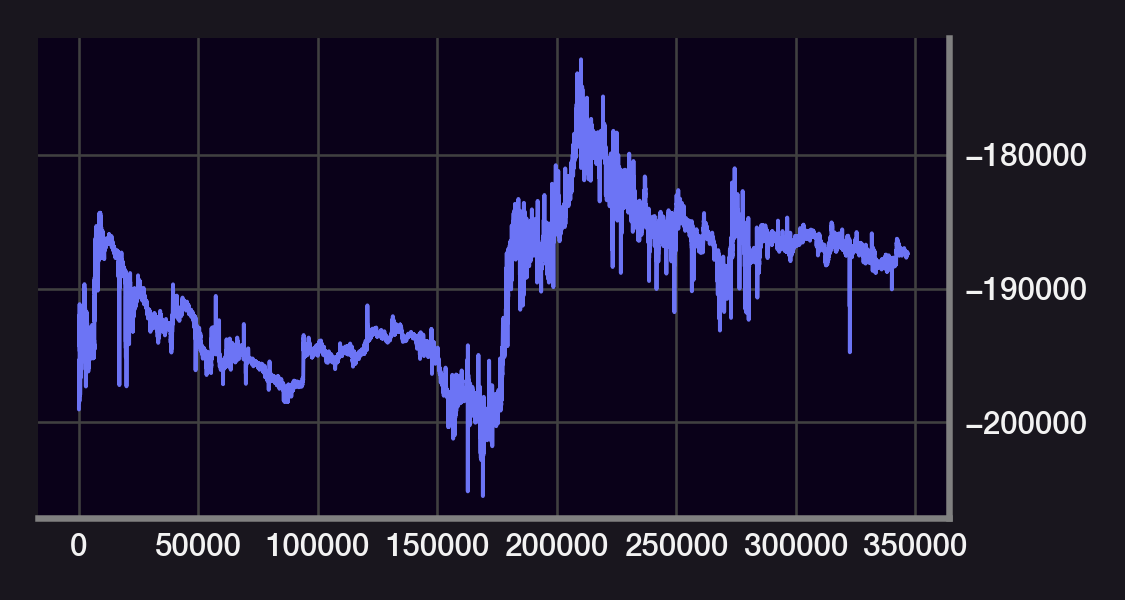

In [460]:
plt.plot(ticksB)

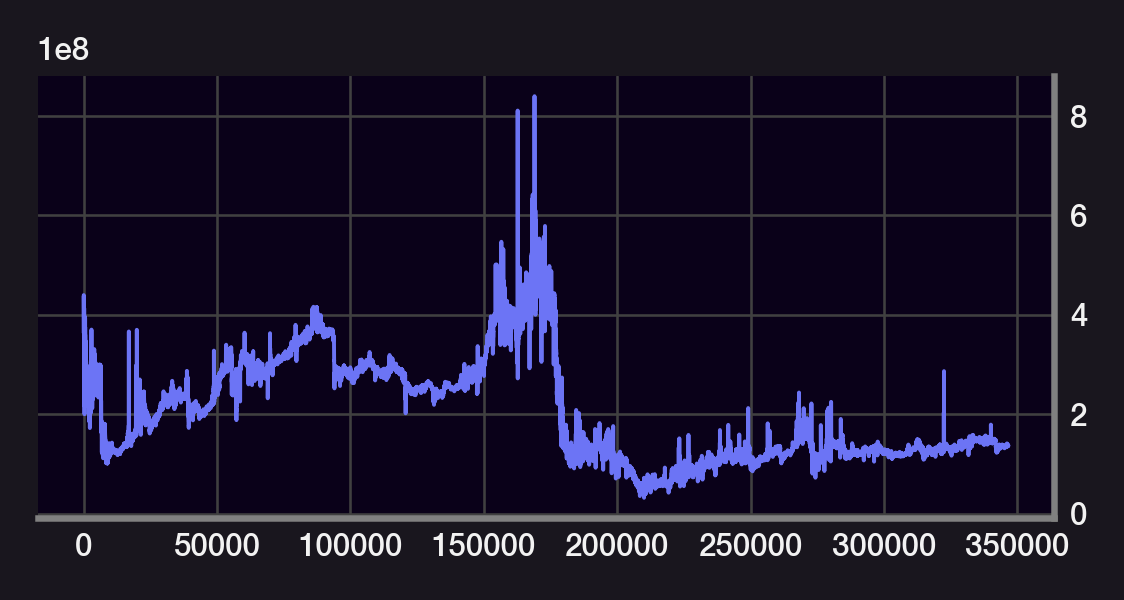

In [462]:
plt.plot(1/sqrtPriceB**2)

In [ ]:
100_000_000